In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score, precision_recall_curve, precision_score
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import seaborn as sns
sns.set_theme('notebook')


Load the data for a quick look'

In [17]:
file_path = r'datasets/financial_data_with_targets.csv'
df = pd.read_csv(file_path)
df.drop(columns= 'index', inplace= True)

pd.set_option('display.max_columns', df.shape[1] + 1)
df.head(10)

,year,month,hour,txn_type,txn_status,error_code,remitter_bank,beneficiary_bank,payer_handle,payer_app,payee_handle,payee_app,payee_requested_amount,payee_settlement_amount,difference_amount,payer_state,payee_state,cred_type,cred_subtype,time_of_day,targets
0,2023,8,0,Refund,Successful,0,Allahabad Bank,Karur Vysya Bank,SCB,Standard Chartered UPI,KOTAK,BHIM KOTAK Pay,54020,54020,0,Punjab,Maharashtra,Debit Card,Prepaid Debit Card,LateNight,0
1,2021,10,0,Payment,Successful,0,Madhya Bihar Gramin Bank,Kotak Mahindra Bank,WASBI,WhatsApp Pay,HDFCBANKJD,JustDial,37670,37670,0,Uttar Pradesh,Rajasthan,Overdraft,Business Overdraft,LateNight,0
2,2019,11,0,Withdrawal,Successful,0,Karur Vysya Bank,United Bank of India,KMBL,Khalijeb,UTKARSHBANK,UTKARSHBANK,22984,22984,0,Haryana,Punjab,Auto Loan,Used Car Loan,LateNight,0
3,2023,9,0,Transfer,Successful,0,HDFC Bank,Corporation Bank,IDBI,BHIM PAyWIZ by IDBI Bank,WASBI,WhatsApp Pay,62038,62038,0,Punjab,Goa,Overdraft,Personal Overdraft,LateNight,0
4,2021,9,0,Fee,Successful,0,Union Bank of India,Bank of India,UNIONBANK,BHIM Union Bank UPI App,NSDL,NSDL,72624,72624,0,Odisha,Maharashtra,Personal Loan,Unsecured Personal Loan,LateNight,0
5,2020,8,0,Deposit,Successful,0,Jammu & Kashmir Bank,Federal Bank,UBOI,BHIM Union Bank UPI App,YESBANK,BHIM YES Pay,15544,15544,0,Bihar,Andhra Pradesh,Auto Loan,New Car Loan,LateNight,0
6,2020,10,0,Payment,Successful,0,ESAF Small Finance Bank,Punjab National Bank (PNB),YESPAY,JusPay Technologies,IMOBILE,ICICI iMobile,70626,70626,0,Kerala,Odisha,Debit Card,Prepaid Debit Card,LateNight,0
7,2023,4,0,Transfer,Successful,0,Fincare Small Finance Bank,NKGSB Co-operative Bank,YAPL,AmazonPay,SBI,BHIM SBI Pay,91678,91678,0,Goa,Punjab,Home Loan,Adjustable-Rate Mortgage (ARM),LateNight,0
8,2023,4,0,Payment,Successful,0,Bank of Baroda,Punjab and Maharashtra Co-operative Bank (PMC),FBL,Cointab,HDFCBANKJD,JustDial,98740,98740,0,Kerala,Goa,Personal Loan,Secured Personal Loan,LateNight,0
9,2020,2,0,Reversal,Successful,0,Utkarsh Small Finance Bank,Lakshmi Vilas Bank,MAHB,BHIM Maha UPI(Bank of Maharashtra),CITI,CITI Bank (Mobile Banking App),10282,10282,0,Uttar Pradesh,Jammu and Kashmir,Home Loan,Adjustable-Rate Mortgage (ARM),LateNight,1


In [16]:
df.describe()

,year,month,hour,payee_requested_amount,payee_settlement_amount,difference_amount,targets
count,55671.000000,55671.000000,55671.000000,55671.000000,55671.000000,55671.000000,55671.000000
mean,2020.981265,6.447468,11.437229,50224.339279,52509.940579,-2285.601300,0.064396
std,1.400540,3.421936,6.660917,29003.090558,32316.082141,11412.568862,0.245460
min,2019.000000,1.000000,0.000000,14.000000,14.000000,-317340.000000,0.000000
25%,2020.000000,3.000000,6.000000,24988.000000,25636.000000,0.000000,0.000000
50%,2021.000000,6.000000,12.000000,50264.000000,51808.000000,0.000000,0.000000
75%,2022.000000,9.000000,18.000000,75530.000000,77826.000000,0.000000,0.000000
max,2023.000000,12.000000,22.000000,99990.000000,416716.000000,27976.000000,1.000000


In [18]:
df.describe(include= 'O')

,txn_type,txn_status,error_code,remitter_bank,beneficiary_bank,payer_handle,payer_app,payee_handle,payee_app,payer_state,payee_state,cred_type,cred_subtype,time_of_day
count,55671,55671,55671,55671,55671,55671,55671,55671,55671,55671,55671,55671,55671,55671
unique,7,8,32,59,59,104,81,104,81,22,22,7,15,8
top,Payment,Successful,0,Indian Bank,Indian Bank,OKAXIS,WhatsApp Pay,OKAXIS,Google Pay,Haryana,Haryana,Credit Card,Secured Personal Loan,Afternoon
freq,10806,50768,50768,2018,1903,1181,2246,1131,2236,4580,4523,11131,3927,9637


In [19]:
df.columns

Index(['year', 'month', 'hour', 'txn_type', 'txn_status', 'error_code',
       'remitter_bank', 'beneficiary_bank', 'payer_handle', 'payer_app',
       'payee_handle', 'payee_app', 'payee_requested_amount',
       'payee_settlement_amount', 'difference_amount', 'payer_state',
       'payee_state', 'cred_type', 'cred_subtype', 'time_of_day', 'targets'],
      dtype='object')

In [23]:
cat_feat_to_keep = ['time_of_day', 'cred_type', 'error_code', 'targets']
num_feat_to_keep = ['payee_requested_amount', 'payee_settlement_amount', 'difference_amount']
feat_to_keep = cat_feat_to_keep + num_feat_to_keep
feat_to_keep

['time_of_day',
 'cred_type',
 'error_code',
 'targets',
 'payee_requested_amount',
 'payee_settlement_amount',
 'difference_amount']

In [24]:
df = df[feat_to_keep]
df.head(10)

,time_of_day,cred_type,error_code,targets,payee_requested_amount,payee_settlement_amount,difference_amount
0,LateNight,Debit Card,0,0,54020,54020,0
1,LateNight,Overdraft,0,0,37670,37670,0
2,LateNight,Auto Loan,0,0,22984,22984,0
3,LateNight,Overdraft,0,0,62038,62038,0
4,LateNight,Personal Loan,0,0,72624,72624,0
5,LateNight,Auto Loan,0,0,15544,15544,0
6,LateNight,Debit Card,0,0,70626,70626,0
7,LateNight,Home Loan,0,0,91678,91678,0
8,LateNight,Personal Loan,0,0,98740,98740,0
9,LateNight,Home Loan,0,1,10282,10282,0


In [54]:
df_with_dummies = pd.get_dummies(df).astype(np.int16)
inputs = df_with_dummies.iloc[:, :-1]
targets = df_with_dummies.iloc[:, -1]

In [55]:
inputs.head()

,targets,payee_requested_amount,payee_settlement_amount,difference_amount,time_of_day_Afternoon,time_of_day_EarlyMorning,time_of_day_Evening,time_of_day_LateAfternoon,time_of_day_LateMorning,time_of_day_LateNight,time_of_day_Morning,...,error_code_U78,error_code_U80,error_code_U85,error_code_U86,error_code_U88,error_code_U89,error_code_U90,error_code_U91,error_code_U92,error_code_U93,error_code_U94
0,0,-11516,-11516,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0
1,0,-27866,-27866,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0
2,0,22984,22984,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0
3,0,-3498,-3498,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0
4,0,7088,7088,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0


In [65]:
scaler = StandardScaler()
scaled_inputs = scaler.fit_transform(inputs)

In [66]:
scaled_inputs, targets

(array([[-0.26235182, -0.88315256, -0.82987697, ..., -0.05567005,
         -0.05127813, -0.05162908],
        [-0.26235182, -1.76132119, -1.69889886, ..., -0.05567005,
         -0.05127813, -0.05162908],
        [-0.26235182,  0.96986382,  1.00383893, ..., -0.05567005,
         -0.05127813, -0.05162908],
        ...,
        [-0.26235182,  0.31685011,  0.35762682, ..., -0.05567005,
         -0.05127813, -0.05162908],
        [-0.26235182,  0.52857737,  0.56714879, ..., -0.05567005,
         -0.05127813, -0.05162908],
        [ 3.81167552, -0.02066743,  0.02362477, ..., -0.05567005,
         -0.05127813, -0.05162908]]),
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 55666    0
 55667    0
 55668    0
 55669    0
 55670    0
 Name: error_code_U96, Length: 55671, dtype: int16)

In [70]:
# Display the distribution of the target variable
print(f'Target distribution: {targets.sum()} positives out of {len(targets)} observations')

Target distribution: 150 positives out of 55671 observations


In [71]:
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size= 0.2, random_state= 42, stratify= targets)

In [73]:
smote = SMOTE(random_state= 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [74]:
# Display the new class distribution
print(f'Resampled target distribution: {sum(y_train_smote)} positives out of {len(y_train_smote)} observations')

Resampled target distribution: 44416 positives out of 88832 observations


In [75]:
model = LogisticRegression(class_weight= 'balanced')
model.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced')

In [76]:
y_pred = model.predict(X_test)

In [77]:
# Evaluating the model
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
print(f"Recall Score: {recall_score(y_test, y_pred)}")
print(f"Precision Score: {precision_score(y_test, y_pred)}")

F1 Score: 1.0
Confusion Matrix:
 [[11105     0]
 [    0    30]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11105
           1       1.00      1.00      1.00        30

    accuracy                           1.00     11135
   macro avg       1.00      1.00      1.00     11135
weighted avg       1.00      1.00      1.00     11135

Recall Score: 1.0
Precision Score: 1.0


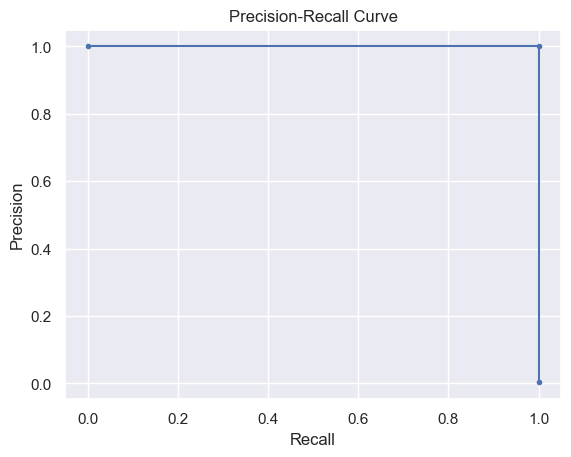

In [78]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()